In [17]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import random as rn


def plot_template(title, x_label, y_label, x_lim=None, y_lim=None):
    """Genera la plantilla para mantener consistencia en el formato
    de cada tabla generada.

    Args:
        title (string): Aplica titulos.
        x_label (float): Título de eje x.
        y_label (float): Título de eje y.
        x_lim ([float], optional): Límite en eje x. Defaults to None.
        y_lim ([float], optional): Límite en eje y. Defaults to None.

    Returns:
        object: Devuelve los objetos de la gráfica modificados con la
        plantilla requerida
    """
    fig, ax = plt.subplots(  # Tamaño de la figura en pulgadas (ancho, alto)
        figsize=(10, 6)
    )

    # Configuración de rótulos y unidades
    ax.set_title(title, fontsize=16)  # Título con tamaño de fuente
    ax.set_xlabel(x_label, fontsize=14)  # Eje x con rótulo y unidades
    ax.set_ylabel(y_label, fontsize=14)  # Eje y con rótulo y unidades

    # Configuración de la escala y las dimensiones
    if x_lim is not None:
        ax.set_xlim(x_lim)  # Limitar el eje x
    if y_lim is not None:
        ax.set_ylim(y_lim)  # Limitar el eje y

    ax.grid(True, which="both", linestyle="--", alpha=0.7)  # Añadir una cuadrícula

    fig.tight_layout()  # Ajusta los elementos para que no se solapen

    return (  # Devolver las figuras y ejes para más modificaciones si es necesario
        fig,
        ax,
    )


# test
if False:
    x = np.linspace(0, 10, 100)
    fig, ax = plot_template("This is a test", "X label", "Y label", [0, 10], [-1, 1])
    ax.scatter(x, [np.sin(i) for i in x], marker="+", color="red")

## Tarea: Modelo climático


### Problema


La probabilidad de que llueva (en Bogotá) crece linealmente desde cero a partir de las 6 am hasta tomar su máximo
a las 2 pm. Luego decrece hasta llegar a cero a las 6 pm.


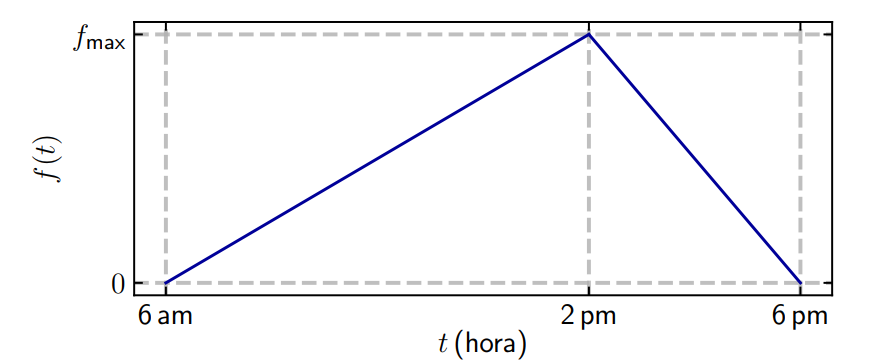


### Preguntas


#### 1. **Densidad de probabilidad**

Resolvemos primero el máximo para este problema utilizando geometría.

$$\text{area} = \frac{12 f_{max}}{2} = 1 \quad \Leftrightarrow \quad f_{max} = \frac{1}{6}$$

Luego, definimos esta función $P$ de _pdf_ como:

$$P(x) = \left\{ \begin{array}{lcc} 0 & si & x < 6 \\  (1/48) x - (3/24) & si & 6 \leq x \leq 14 \\  -(1/24) x + (3/4) & si & 14 < x \leq 18 \\  0 & si & x > 18 \end{array} \right. $$

Se define el objeto `prob_lluvia(periodo)` para definir un estado general de lo relacionado con el problema, tanto su _pdf_ con `P(x)`, las funciones que definen la probabilidad `.integral(hora)` y `.promedio(hora)`.


In [ ]:
class model_rain:
    """Genera el objeto modelo de probabilidad de lluvia, inicializa los parámetros,
    genera la lista de horas debida y toma la función de densidad de probabilidad y
    la discretiza.
    """

    def __init__(self, period):
        """Se inicializan las variables y se establece la particion horas.

        Args:
            periodo (int, float): El periodo en el cuál se toman las particiones del tiempo.
        """

        self.period = period
        self.begin = 6  # hora inicial
        self.end = 18  # hora final
        self.N = 1  # Normalización.
        self.f_max = self.N / 6  # Máximo de probabilidad.
        self.sum_prob = 0  # Es la suma de probabilidades para normalizar

        # Paso
        self.step = int((self.end - self.begin) / self.period) + 1
        # Partición
        self.hours = np.linspace(self.begin, self.end, num=self.step)

    def PDF(self, x):
        """
        Función de densidad de probabilidad del modelo de la lluvia dado como
        función.

        Parameters:
        x (float): Variable aleatoria.

        Returns:
        float: probabilidad del punto.
        """

        if x < 6:
            return 0
        elif 6 <= x <= 14:
            return ((1 / 8) * x - (3 / 4)) * self.f_max
        elif 14 < x <= 18:
            return (-(1 / 4) * x + (9 / 2)) * self.f_max
        elif x > 18:
            return 0

    def cell(self, hour):
        """
        Devuelve el valor discretizado de la hora, haciendo una función piso
        para según la partición que se tenga y con una tolerancia de 1e-4.

        Parameters:
        hora (float): Variable de tiempo hora.

        Returns:
        float: Valor discretizado o 0 si no lo encontró.
        """

        for discreet_hour in self.hours:
            if (
                hour >= discreet_hour
                and hour < (discreet_hour + self.period)
                and not (np.isclose(hour, discreet_hour + self.period, atol=1e-4))
            ):
                return discreet_hour
        return 0

    def prob_integrating(self, hour):
        """
        Encuentra la probabilidad de la distribución discretizada a través del
        proceso de encontrar el área por trapecio

        Parameters:
        hora (float): Variable de tiempo hora absoluta o militar.

        Returns:
        float: Probabilidad sin normalizar.
        """

        if hour < self.begin or hour > self.end:
            return 0
        hour = self.cell(hour)
        return self.period * (self.P(hour) + self.P(hour + self.period)) / 2

    def prob_averaging(self, hour):
        """Toma la hora absoluta (0-24 horas) y devuelve la probabilidad
        como media entre la función discretizada por el periodo.

        Args:
            hour (float): Variable de tiempo como hora absoluta (militar)

        Returns:
            float: Probabilidad sin normalizar.
        """

        if hour < self.begin or hour > self.end:
            return 0
        hour = self.cell(hour)
        return self.P(hour + self.period / 2)  # Promedio valores

    def prob_integrating_norm(self, hour):
        return (
            self.N / np.sum([self.prob_integrating(h) for h in self.hours])
        ) * self.prob_integrating(hour)


# Algunas comprobaciones
model = model_rain(period=1)
print(
    f"""
      Probabilidad: {model.integrating(12)} 
      Probabilidad total promedio: {np.sum([model.promedio( hora ) for hora in model.horas]):.4f}
      Probabilidad total integral: {np.sum([model.integral( hora ) for hora in model.horas]):.4f}
"""
)

[model.promedio(hora) - model.integral(hora) for hora in model.horas]

NameError: name 'prob_lluvia' is not defined

Se comprueba entonces que:

- Las funciones de probabilidad están normalizadas a 1.
- Las diferencias entre las formas de tomar la probabilidad son despreciables.


#### 2. **Obtener $f_{max}$**

Cómo se indicó en el punto previo, se resolvió tomando geométricamente el área y resolviendo el punto máximo para que la función de probabilidad fuera normalizada a 1. Como se sugiere también, dado que $f_{max}$ es el carácter que provee a la función la normalizacion, que se pueda generalizar como:

$$\text{area} = \frac{12 f_{max}}{2} = N \quad \Leftrightarrow \quad f_{max} = \frac{N}{6}$$

Luego, definimos esta función $P$ de _pdf_ como:

$$P(x) = \left\{ \begin{array}{lcc} 0 & si & x < 6 \\  f_{max}((1/8) x - (3/4)) & si & 6 \leq x \leq 14 \\  f_{max}(-(1/4) x + (9/2)) & si & 14 < x \leq 18 \\  0 & si & x > 18 \end{array} \right. $$

Podemos despejar la normalización para tenerla como parámetro en nuestro objeto `prob_lluvia` y de esa manera generalizarlo aún más.


#### 3. Gráficas y Función Acumulativa


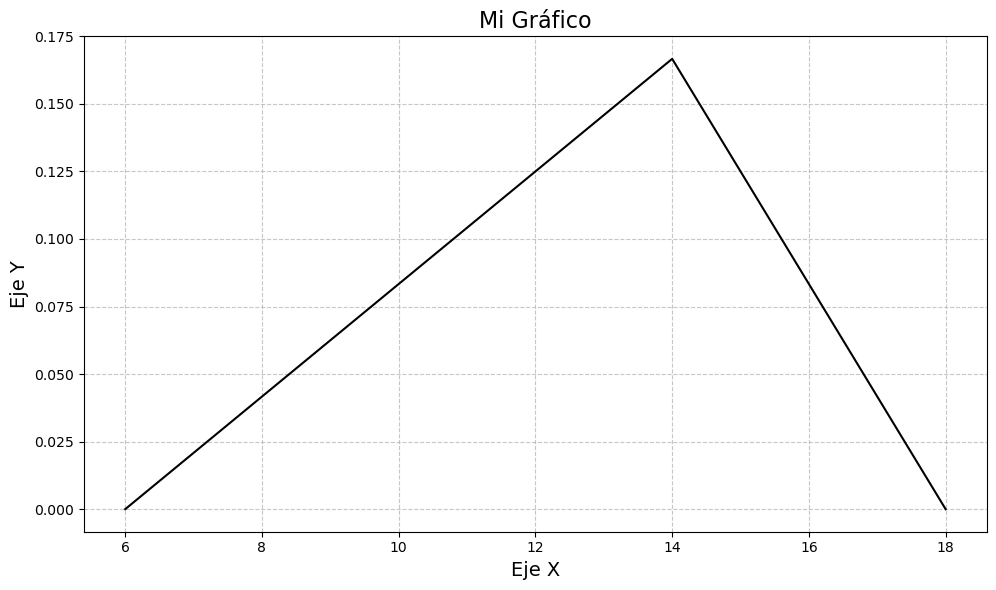

In [12]:
# Ejemplo de uso
pl = prob_lluvia(1)

x_vals = pl.horas

x = np.linspace(min(x_vals), max(x_vals), 1090)
fig, ax = configure_plot("Mi Gráfico", "Eje X", "Eje Y")
ax.plot(x, [pl.P(i) for i in x], color="black", label="pdf")

plt.show()

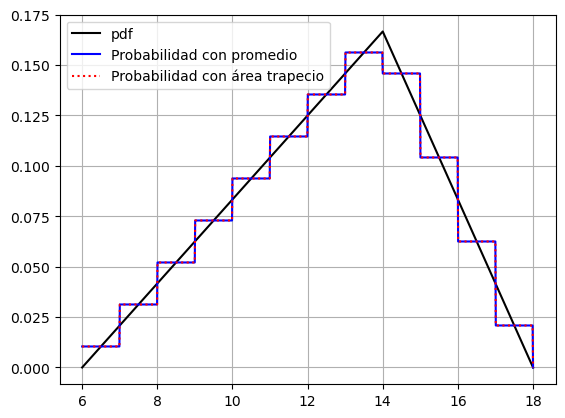

In [ ]:
pl = prob_lluvia(1)

x_vals = pl.horas

x = np.linspace(min(x_vals), max(x_vals), 1090)
plt.plot(x, [pl.P(i) for i in x], color="black", label="pdf")
plt.plot(
    x,
    [pl.promedio(horas) for horas in x],
    color="blue",
    label="Probabilidad con promedio",
)
plt.plot(
    x,
    [pl.integral(horas) for horas in x],
    ls="dotted",
    color="red",
    label="Probabilidad con área trapecio",
)
plt.grid()

# Añadir leyenda para más claridad
plt.legend()

# Mostrar el gráfico
plt.show()

Se genera la función acumulativa $F$ y se grafica.


[0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0]


[0,
 0.010416666666666666,
 0.041666666666666664,
 0.09375,
 0.16666666666666666,
 0.26041666666666663,
 0.37499999999999994,
 0.5104166666666666,
 0.6666666666666666,
 0.8125,
 0.9166666666666666,
 0.9791666666666666,
 1.0,
 1.0]

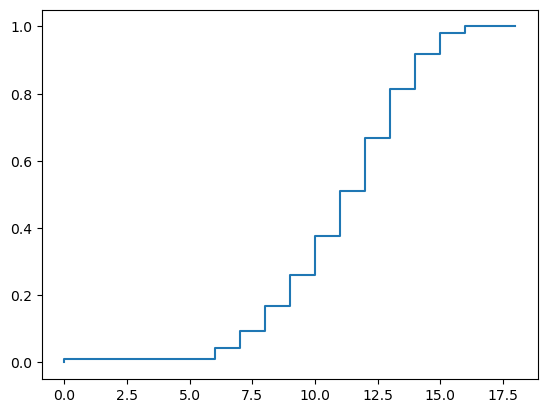

In [ ]:
# acumulador
F = [0]
acum = 0
for hour in pl.horas:
    acum += pl.integral(hour)
    F.append(acum)

x_val = [0]
for hour in pl.horas:
    x_val.append(hour)
print(x_val)

plt.plot(x_val, F, ds="steps")

F

#### 4. Experimento


Se genera el experimento en historias (eventos) aleatorios.


In [ ]:
model = prob_lluvia(1)


# Por cada historia
def experimento(pl, historias):
    dim_pdf = len(pl.horas)
    # rn.seed(123)
    histograma = np.array([0] * dim_pdf)
    for i in range(historias):
        r = rn.random()
        # Busqueda ubicacion en el histograma
        for j in np.arange(1, dim_pdf):
            if r >= F[j - 1] and r < F[j]:
                bingo = j
                break
        histograma[bingo] += 1
    return histograma

Pruebe cambiando el valor de `eventos` para cada valor deseado:

- 30
- 365
- 1000
- $10^6$


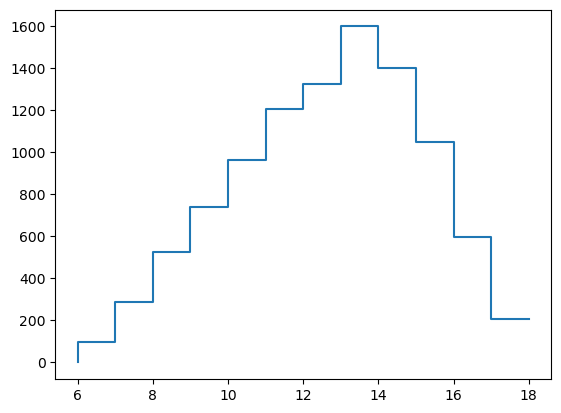

In [34]:
eventos = 10000

eventos = int(eventos)

x_vals = pl.horas

# experimental
plt.plot(pl.horas, experimento(pl, eventos), ds="steps")

#### 5. Verificar


(a) Se verifica que el comportamiento es como se desea determinar solapando cada gráfica requerida.


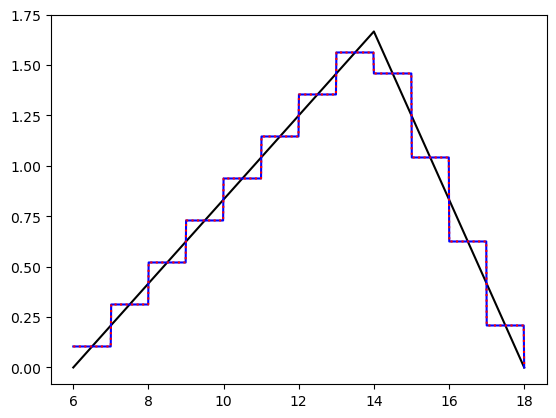

In [ ]:
eventos = 10

eventos = int(eventos)

x_vals = pl.horas

# teórica
x = np.linspace(min(x_vals), max(x_vals), 1000)
plt.plot(x, [pl.P(i) * eventos for i in x], color="black", label="pdf")
plt.plot(
    x,
    [pl.promedio(horas) * eventos for horas in x],
    color="blue",
    label="Probabilidad con promedio",
)
plt.plot(
    x,
    [pl.integral(horas) * eventos for horas in x],
    ls="dotted",
    color="red",
    label="Probabilidad con área trapecio",
)

# experimental

**(b)** Para comparar los resultados, se escala proporcional el número de eventos se prueben, dado que la probabilidad toma en cuenta la proporción de la población que se va a medir tan solo hace falta multiplicarlos como `pl.promedio(horas) * eventos` visto anteriormente en el código.


#### 7. Si no llueve


Si la probabilidad de que llueva es 0.7


In [ ]:
objeto = prob_lluvia(1)

p_llueve = 0.7
[objeto.integral(x) * p_llueve for i in range(d)]

1


P(x) \* p_llueve = la lluvia ocurre en una hora especifica x
